# CSE 8803 EPI - Data Science for Epidemiology
## Homework 1
## Clayton Horsfall - 903618636
### 9/20/2020

#### -----------------------------------------------------
#### Q1.6

In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy.integrate import odeint, ode, solve_ivp

         t         S         I         R
0      0.0  0.990000  0.010000  0.000000
1      1.0  0.988986  0.010502  0.000512
2      2.0  0.987922  0.011027  0.001051
3      3.0  0.986806  0.011578  0.001616
4      4.0  0.985636  0.012155  0.002209
..     ...       ...       ...       ...
196  196.0  0.209490  0.016092  0.774418
197  197.0  0.209158  0.015631  0.775211
198  198.0  0.208836  0.015183  0.775981
199  199.0  0.208524  0.014747  0.776729
200  200.0  0.208221  0.014323  0.777456

[201 rows x 4 columns]


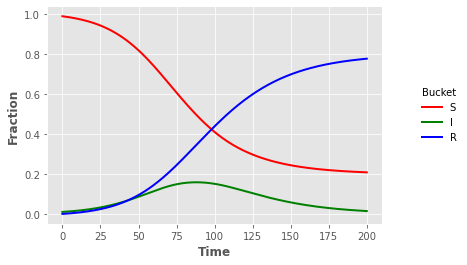

In [2]:
def sir_ode(times,init,parms):
    b, g = parms
    S,I,R = init
    # ODEs
    dS = -b*S*I
    dI = b*S*I-g*I
    dR = g*I
    return [dS,dI,dR]

parms = [0.1,0.05]
init = [0.99,0.01,0.0]
times = np.linspace(0,200,201)

sir_sol = solve_ivp(fun=lambda t, y: sir_ode(t, y, parms), t_span=[min(times),max(times)], y0=init, t_eval=times)
sir_out = pd.DataFrame({"t":sir_sol["t"],"S":sir_sol["y"][0],"I":sir_sol["y"][1],"R":sir_sol["y"][2]})

print(sir_out)

##viz
import matplotlib.pyplot as plt
plt.style.use("ggplot")
sline = plt.plot("t","S","",data=sir_out,color="red",linewidth=2)
iline = plt.plot("t","I","",data=sir_out,color="green",linewidth=2)
rline = plt.plot("t","R","",data=sir_out,color="blue",linewidth=2)
plt.xlabel("Time",fontweight="bold")
plt.ylabel("Fraction",fontweight="bold")
legend = plt.legend(title="Bucket",loc=5,bbox_to_anchor=(1.25,0.5))
frame = legend.get_frame()
frame.set_facecolor("white")
frame.set_linewidth(0)


#### -----------------------------------------------------
#### Q1.7


In [3]:
import networkx as nx
import h2o
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
S_sum = 0
I_sum = 0
R_sum = 0
h2o.no_progress()
for stoch in range(0,100):
    #network definition
    g= nx.erdos_renyi_graph(100,.1)

    #model selection
    model = ep.SIRModel(g)

    # Model Configuration
    config = mc.Configuration()
    config.add_model_parameter('beta', 0.0186)
    config.add_model_parameter('gamma', 0.00613741)
    config.add_model_parameter("fraction_infected", 0.01)
    model.set_initial_status(config)

    # Simulation
    iterations = model.iteration_bunch(200)
    trends = model.build_trends(iterations)

    #from bokeh.io import output_notebook, show
    #from ndlib.viz.bokeh.DiffusionTrend import DiffusionTrend
    # Visualization
    viz = DiffusionTrend(model, trends)
    #viz.plot("diffusion.pdf")
    #viz.plot()
    #print(iterations[-1]['node_count'][0])
    S_sum = S_sum + iterations[-1]['node_count'][0]
    I_sum = I_sum + iterations[-1]['node_count'][1]
    R_sum = R_sum + iterations[-1]['node_count'][2]

    #viz = DiffusionTrend(model, trends)
    #p = viz.plot(width=800, height=800)
    #p.plot()
    #show(p)

    #from ndlib.viz.bokeh.DiffusionPrevalence import DiffusionPrevalence

    #viz2 = DiffusionPrevalence(model, trends)
    #p2 = viz2.plot(width=800, height=800)
    
print("Susceptible Population out of 100 people: " + str(S_sum/100))
print("Infected Population out of 100 people: " + str(I_sum/100))
print("Recovered Population out of 100 people: " + str(R_sum/100))

no display found. Using non-interactive Agg backend


100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1806.98it/s]


Susceptible Population out of 100 people: 1.04
Infected Population out of 100 people: 36.16
Recovered Population out of 100 people: 62.8


#### -----------------------------------------------------
#### Q1.8

In [4]:
b = 0.1
g = 0.1
parms = [b, g]

S = 0.9845
I = 0.015
R = 1 - S - I
init = [S, I, R]

time = np.linspace(1, 30, 30)

df = pd.read_csv('C:/Users/Clayton/Desktop/Georgia Tech/CSE_8803_EPI/datasets for HW1/q1.8/COV19_GA_April.csv')
#df = C:\Users\Clayton\Desktop\Georgia Tech\CSE_8803_EPI\datasets for HW1\q1.8
r_observed = df["fraction_of_deaths"].tolist()

def loss(parms, init, time, r_observed):
    S, I, R = init
    b, g = parms
    solution = solve_ivp(fun = lambda t, y: sir_ode(t, y, parms), t_span = [min(time), max(time)], y0 = init, t_eval = time)
    output = pd.DataFrame({'t': solution['t'], 'S': solution['y'][0], 'I': solution['y'][1], 'R': solution['y'][2]})
    r = np.asarray(output["R"].tolist())
    loss = np.subtract(r, r_observed)**2
    loss = loss.sum()
    return loss

solution = solve_ivp(fun = lambda t, y: sir_ode(t, y, parms), t_span = [min(time), max(time)], y0 = init, t_eval = time)
output = pd.DataFrame({'t': solution['t'], 'S': solution['y'][0], 'I': solution['y'][1], 'R': solution['y'][2]})
result = scipy.optimize.minimize(loss, parms, args = (init, time, r_observed), method= 'L-BFGS-B', bounds=[(0.00000001, 1), (0.00000001, 1)])
best_params = print(result.x)
#Plot S(t), I(t), R(t) vs time (just like the plots we saw in slide 19, lecture 3).
#Show in the same figure the ‘ground-truth’ R_observed(t) you used to calibrate.

output_plus = output.copy()
output_plus['observed_R'] = r_observed
output_plus
#I think I'm doing something wrong here

[0.0186     0.00613741]


,t,S,I,R,observed_R
0,1.0,0.984500,0.015000,0.000500,0.000513
1,2.0,0.983026,0.014976,0.001999,0.000587
2,3.0,0.981556,0.014949,0.003495,0.000660
3,4.0,0.980091,0.014921,0.004989,0.000693
4,5.0,0.978631,0.014890,0.006479,0.000730
5,6.0,0.977177,0.014857,0.007966,0.000980
6,7.0,0.975728,0.014822,0.009450,0.001160
7,8.0,0.974284,0.014785,0.010931,0.001233
8,9.0,0.972847,0.014746,0.012407,0.001373
9,10.0,0.971415,0.014705,0.013880,0.001417


#### -----------------------------------------------------
#### Q1.9

In [6]:
S_sumH = 0
I_sumH = 0
R_sumH = 0
S_sumTh = 0
I_sumTh = 0
R_sumTh = 0
S_sum10 = 0
I_sum10 = 0
R_sum10 = 0
for stoch in range(0,2):
    #network definition
    g= nx.erdos_renyi_graph(100,.1)

    #model selection
    model = ep.SIRModel(g)

    # Model Configuration
    config = mc.Configuration()
    config.add_model_parameter('beta', 0.0186)
    config.add_model_parameter('gamma', 0.00613741)
    config.add_model_parameter("fraction_infected", 0.015)
    model.set_initial_status(config)

    # Simulation
    iterations = model.iteration_bunch(900)
    trends = model.build_trends(iterations)

    # Visualization
    viz100 = DiffusionTrend(model, trends)
    #viz.plot("diffusion.pdf")
    #print(iterations[-1]['node_count'][0])
    S_sumH = S_sumH + iterations[-1]['node_count'][0]
    I_sumH = I_sumH + iterations[-1]['node_count'][1]
    R_sumH = R_sumH + iterations[-1]['node_count'][2]

for stoch in range(0,2):
    #network definition
    g= nx.erdos_renyi_graph(1000,.1)

    #model selection
    model = ep.SIRModel(g)

    # Model Configuration
    config = mc.Configuration()
    config.add_model_parameter('beta', 0.0186)
    config.add_model_parameter('gamma', 0.00613741)
    config.add_model_parameter("fraction_infected", 0.015)
    model.set_initial_status(config)

    # Simulation
    iterations = model.iteration_bunch(900)
    trends = model.build_trends(iterations)

    # Visualization
    viz1000 = DiffusionTrend(model, trends)
    #viz.plot("diffusion.pdf")
    #print(iterations[-1]['node_count'][0])
    S_sumTh = S_sumTh + iterations[-1]['node_count'][0]
    I_sumTh = I_sumTh + iterations[-1]['node_count'][1]
    R_sumTh = R_sumTh + iterations[-1]['node_count'][2]

for stoch in range(0,2):
    #network definition
    g= nx.erdos_renyi_graph(10000,.1)

    #model selection
    model = ep.SIRModel(g)

    # Model Configuration
    config = mc.Configuration()
    config.add_model_parameter('beta', 0.0186)
    config.add_model_parameter('gamma', 0.00613741)
    config.add_model_parameter("fraction_infected", 0.015)
    model.set_initial_status(config)

    # Simulation
    iterations = model.iteration_bunch(900)
    trends = model.build_trends(iterations)

    # Visualization
    viz10000 = DiffusionTrend(model, trends)
    #viz.plot("diffusion.pdf")
    #print(iterations[-1]['node_count'][0])
    S_sum10 = S_sum10 + iterations[-1]['node_count'][0]
    I_sum10 = I_sum10 + iterations[-1]['node_count'][1]
    R_sum10 = R_sum10 + iterations[-1]['node_count'][2]
    
    
#viz100.plot()
#viz1000.plot()
#viz10000.plot()
print("Susceptible Population out of 100 people: " + str(S_sumH/2))
print("Infected Population out of 100 people: " + str(I_sumH/2))
print("Recovered Population out of 100 people: " + str(R_sumH/2))
print("-----")
print("Susceptible Population out of 1000 people: " + str(S_sumTh/2))
print("Infected Population out of 1000 people: " + str(I_sumTh/2))
print("Recovered Population out of 1000 people: " + str(R_sumTh/2))
print("-----")
print("Susceptible Population out of 10000 people: " + str(S_sum10/2))
print("Infected Population out of 10000 people: " + str(I_sum10/2))
print("Recovered Population out of 10000 people: " + str(R_sum10/2))

100%|████████████████████████████████████████████████████████████████████████████████| 900/900 [02:43<00:00,  5.51it/s]


Susceptible Population out of 100 people: 0.5
Infected Population out of 100 people: 2.0
Recovered Population out of 100 people: 97.5
-----
Susceptible Population out of 1000 people: 0.0
Infected Population out of 1000 people: 4.0
Recovered Population out of 1000 people: 996.0
-----
Susceptible Population out of 10000 people: 0.0
Infected Population out of 10000 people: 39.0
Recovered Population out of 10000 people: -9961.0


#### -----------------------------------------------------
#### Q3.2

In [7]:
import numpy as np
import pandas as pd
import datetime
import time

In [8]:
network_dict = {}
movie_dict = {}
movie_timestamp = {}

In [9]:
nw_df = pd.read_table('C:/Users/Clayton/Desktop/Georgia Tech/CSE_8803_EPI/datasets for HW1/q3/network.txt', header = None, delim_whitespace=True)
rtg_df = pd.read_table('Ratings.timed.txt')

In [10]:
for i in nw_df[0].unique():
    network_dict[i] = list(nw_df[nw_df[0]==i][1])

In [11]:
for i in rtg_df['userid'].unique():
    temp_dict = {}
    for index, row in rtg_df[rtg_df.userid==i][['movieid','date']].iterrows():
        temp_dict[row['movieid']] = time.mktime(datetime.datetime.strptime(row['date'], "%Y-%m-%d").timetuple())
    movie_dict[i] = temp_dict

In [12]:
#stp = 0
for i in network_dict:
    v_set = set()
    u_set = set()
    for j in network_dict[i]:
        try:
            v_set = set(movie_dict[i].keys())
            u_set = set(movie_dict[j].keys())
        except:
            pass
        try:
            intsct = list(v_set & u_set)
            if len(intsct) > 0:
                time_set = set()
                for k in intsct:
                    if int(movie_dict[i][k]) < int(movie_dict[j][k]):
                        time_set.add(k)
                #print(str(i) +" and " + str(j) + " share this set: " + str(intsct))
                #print(str(i) +" infected " + str(j) + " with this set: " + str(list(time_set)))
                
                ##### IF YOU WANT ALL P'S, NOT JUST THOSE GREATER THAN 0, comment-out the IF line below and 
                ##### tab-out the 'print', comment-out the 'pass' in the 'else:', and uncomment the 'print in the 'else'
                if float(len(time_set))/float(len(intsct)) > 0:
                    print("person v (userid " + str(i) + ") infects person u (userid " + str(j) +") with probability " + str(float(len(time_set))/float(len(intsct))))
            else:
                pass
                #print("person v (userid " + str(i) + ") infects person u (userid " + str(j) +") with probability 0.0")
        except:
            pass
    #stp = stp + 1
    #if stp==20:
        #break

person v (userid 8) infects person u (userid 963) with probability 1.0
person v (userid 15) infects person u (userid 975) with probability 1.0
person v (userid 15) infects person u (userid 2240) with probability 1.0
person v (userid 15) infects person u (userid 2246) with probability 1.0
person v (userid 15) infects person u (userid 2279) with probability 1.0
person v (userid 15) infects person u (userid 2296) with probability 1.0
person v (userid 15) infects person u (userid 2303) with probability 1.0
person v (userid 15) infects person u (userid 2308) with probability 1.0
person v (userid 15) infects person u (userid 2314) with probability 1.0
person v (userid 15) infects person u (userid 2322) with probability 1.0
person v (userid 15) infects person u (userid 2325) with probability 1.0
person v (userid 15) infects person u (userid 2328) with probability 1.0
person v (userid 15) infects person u (userid 2343) with probability 1.0
person v (userid 15) infects person u (userid 2350) wi